# Simple MNIST Model

In this notebook we will create a simple model to predicts what letter is written in a 28x28 image based on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).  This is done via a single fully connected layer Neural Network on a flattened version of the image.

### Import Tensorflow & Download data

In [33]:
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Date exloration

### Define Variables

In [3]:
# Input Images
x = tf.placeholder(tf.float32, [None, 784])
# Weights
W = tf.Variable(tf.zeros([784, 10]))
# Bias
b = tf.Variable(tf.zeros([10]))
# True Values
y_ = tf.placeholder(tf.float32, [None, 10])


### Define Model

In [4]:
# Prediction
y = tf.matmul(x, W) + b

# Cross entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
# Optimizer
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### Train Model

In [5]:
sess = tf.InteractiveSession()
# Initialize Variables
tf.global_variables_initializer().run()

for _ in range(10000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={
        x: batch_xs,
        y_: batch_ys
    })

### Calculate Accuracy

In [6]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={
    x:mnist.test.images, 
    y_: mnist.test.labels
}))

0.9229


In [25]:
def plot_predictions(image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    prob = y.eval(feed_dict={x: image_list})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None

In [26]:
def create_plot_adversarial_images(x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for _ in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image})
        
        # Create darray of 3 images - orig, noise/delta, adversarial
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)

        # Print/plot images and return probabilities
        probs = plot_predictions(img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
    
    return probs_per_step

In [27]:
index_of_2s = np.nonzero(mnist.test.labels[0:1000][:,2])[0]
rand_index = np.random.randint(0, len(index_of_2s))
image_norm = mnist.test.images[index_of_2s[rand_index]]
image_norm = np.reshape(image_norm, (1, 784))
label_adv = [0,0,0,0,0,0,1,0,0,0] # one hot encoded, adversarial label 6

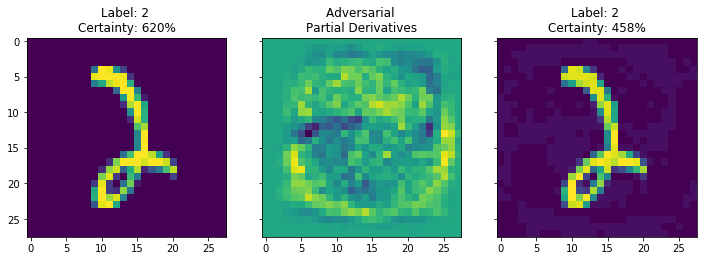

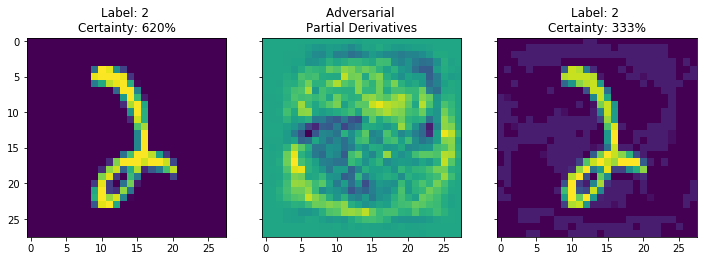

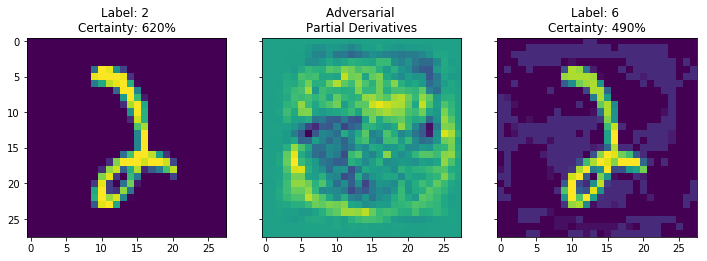

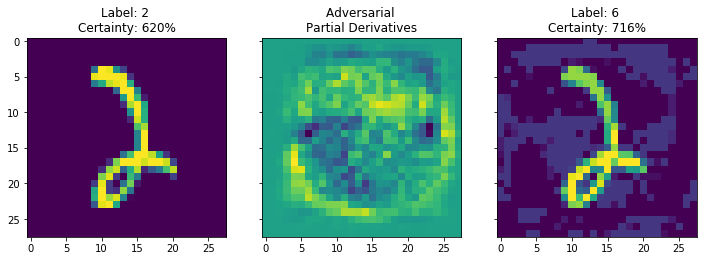

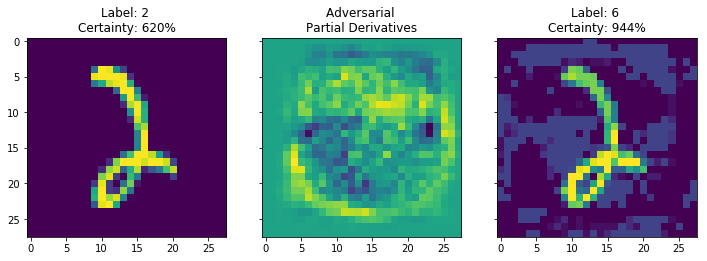

[]

In [34]:
create_plot_adversarial_images(image_norm, label_adv, lr=0.2, n_steps=5)